## Extract Transfer values from Inception v3 and cluster them

Pass images through Inception v3 model.  

Save tranfer values (last layer before dense) that contain useful information.

Reduce dim with PCA/tSNE and cluster

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image

from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from PIL import Image

# for clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Download the Inception v3 Model

85 MB

default input size = 299 x 299, format (299, 299, 3), but can be smaller, eg (120, 120, 3)

In [2]:
# create the base pre-trained model
inc_model = InceptionV3(weights = 'imagenet', 
                        include_top = False) # include the fully-connected layer


W0723 07:31:16.745165 139939529119488 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 07:31:16.783842 139939529119488 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 07:31:16.789158 139939529119488 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 07:31:16.819158 139939529119488 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/conda_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_d

In [3]:
inc_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


## Predict transfer values on 2 images

In [7]:
raw_data = pd.read_csv('/home/ubuntu/students/phenocat/VAE_sandbox_doris/labeled_data_set.csv')
raw_data['filename'].iloc[1]

'CN-CP611_N05_T0001F006L01A01Z01C01_052.png'

In [8]:
img_path = '/home/ubuntu/students/phenocat/small_data_set_top/small_data_set/CN-CP616_N04_T0001F010L01A01Z01C01_100.png'
img_path2 = '/home/ubuntu/students/phenocat/small_data_set_top/small_data_set/CN-CP611_N05_T0001F006L01A01Z01C01_052.png'

img = image.load_img(img_path)
img_vector = image.img_to_array(img)
img_vector = np.expand_dims(img_vector, axis = 0) # adds batch dim --> (1, 256, 256, 3)
img_vector.shape

img2 = image.load_img(img_path2)
img_vector2 = image.img_to_array(img2)
img_vector2 = np.expand_dims(img_vector2, axis = 0) # adds batch dim --> (1, 256, 256, 3)

image_vecs = np.append(img_vector, img_vector2, axis=0)

image_vecs.shape

(2, 256, 256, 3)

In [9]:
features = inc_model.predict(image_vecs)

In [10]:
features.shape

(2, 6, 6, 2048)

In [11]:
transfer_feat = []
for i in range(0, features.shape[0]):
    transfer_feat.append(np.ravel(features[i]))
       

In [12]:
len(transfer_feat[0])

73728

## Predict transfer values on labeled data set

In [31]:
raw_data = pd.read_csv('/home/ubuntu/students/phenocat/VAE_sandbox_doris/labeled_data_set.csv')
raw_data = pd.DataFrame(raw_data)
data = raw_data.sample(frac = 1).reset_index(drop = True) # randomize rows

data.head()

,filename,gene_name,phenotype
0,CN-CP612_J06_T0001F007L01A01Z01C01_010.png,STK19,1
1,CN-CP614_D18_T0001F005L01A01Z01C01_067.png,TOP1,4
2,CN-CP611_I03_T0001F016L01A01Z01C01_086.png,MAPK8,4
3,CN-CP612_L12_T0001F001L01A01Z01C01_027.png,MAP3K13,3
4,CN-CP615_F09_T0001F009L01A01Z01C01_022.png,STK4,4


### Pre-process images

In [33]:
path_to_folder = '/home/ubuntu/students/phenocat/small_data_set_top/small_data_set/'

datagen = image.ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(data, directory = path_to_folder, x_col='filename', 
                                             target_size = (256, 256), color_mode='rgb',
                                             shuffle = False, class_mode= None,batch_size = 1)


labels = data['phenotype']

Found 1426 validated image filenames.


### Predict transfer values

In [34]:
transfer_vals = inc_model.predict_generator(test_generator, steps = len(data))

### Flatten transfer values

In [35]:
mat_transfer_vals = []
for i in range(0, transfer_vals.shape[0]):
    mat_transfer_vals.append(np.ravel(transfer_vals[i]))
    
np.save('mat_transfer_vals', mat_transfer_vals)
np.save('mat_transfer_vals_labels', labels)

In [40]:
np.size(mat_transfer_vals, 1)

73728

## Clustering transfer values

### Reduce dimensions with pca

In [41]:
reduced_dims = 50

pca = PCA(.95) # final number of components will explain 95% variance
pca_values = pca.fit_transform(mat_transfer_vals) 


In [42]:
np.size(pca_values, 1)

819

### Cluster PCs with kMeans

In [45]:
# kmeans clustering
result_kmeans = KMeans(n_clusters = 3).fit(pca_values)
cluster_ID = result_kmeans.labels_

### Use t-SNE to visualize clusters

In [50]:
tsne_data = TSNE(n_components = 2, perplexity = 20, verbose = 1).fit_transform(pca_values)


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1426 samples in 0.385s...
[t-SNE] Computed neighbors for 1426 samples in 17.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1426
[t-SNE] Computed conditional probabilities for sample 1426 / 1426
[t-SNE] Mean sigma: 40.499108
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.581306
[t-SNE] KL divergence after 1000 iterations: 2.077416


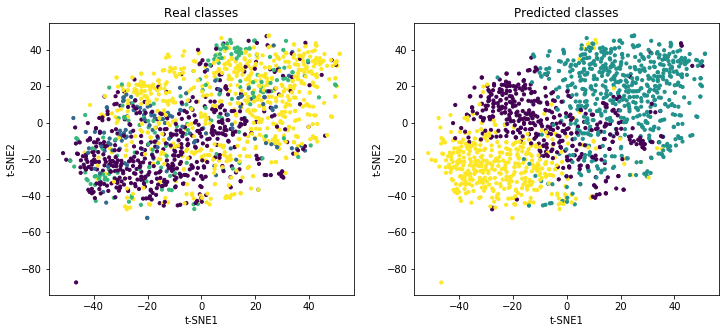

In [52]:
plt.rcParams['figure.figsize'] = (12, 5)

fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.scatter(x = tsne_data[:,0], y = tsne_data[:,1], c = labels, s = 10)
ax1.set_xlabel('t-SNE1')
ax1.set_ylabel('t-SNE2')
ax1.set_title('Real classes')

ax2.scatter(x = tsne_data[:,0], y = tsne_data[:,1], c = cluster_ID, s = 10)
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.set_title('Predicted classes')

None

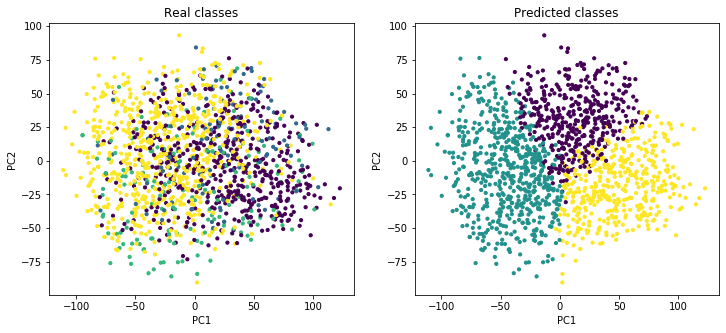

In [53]:
plt.rcParams['figure.figsize'] = (12, 5)

fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.scatter(x = pca_values[:,0], y = pca_values[:,1], c = labels, s = 10)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Real classes')

ax2.scatter(x = pca_values[:,0], y = pca_values[:,1], c = cluster_ID, s = 10)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Predicted classes')

None

### Clustergram with labels